In [6]:
import IPython
import librosa

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
import subprocess
from numpy.linalg import norm

In [2]:
"""
@FileName: basic_functions.py
@Description: Implement basic_functions
@Author  : Ryuk
@CreateDate: 2019/11/13 13:47
@LastEditTime: 2019/11/13 13:47
@LastEditors: Please set LastEditors
@Version: v1.0
"""


def normalization(data):
    """
    normalize data into [-1, 1]
    :param data: input data
    :return: normalized data
    """
    normalized_data = 2 * (data - min(data)) / (max(data) - min(data)) - 1
    return normalized_data


def enframe(samples, beta=8.5, overlapping=0, window_length=240, window_type='Rectangle'):
    """
    divede samples into frame
    :param samples:
    :param beta: parameter for kaiser window
    :param frame_num:
    :param window_length:
    :param window_type:
    :return: enframed frames
    """

    frames_num = len(samples) // (window_length - overlapping)
    frames = np.zeros([frames_num, window_length])
    for i in range(frames_num):
        start = i * (window_length - overlapping)
        end = start + window_length
        data = samples[start:end]

        N = len(data)
        x = np.linspace(0, N - 1, N, dtype=np.int64)

        if window_type == 'Rectangle':
            data = data
        elif window_type == 'Triangle':
            for i in range(N):
                if i < N:
                    data[i] = 2 * i / (N - 1)
                else:
                    data[i] = 2 - 2 * i / (N - 1)
        elif window_type == 'Hamming':
            w = 0.54 - 0.46 * np.cos(2 * np.pi * x / (N - 1))
            data = data * w
        elif window_type == 'Hanning':
            w = 0.5 * (1 - np.cos(2 * np.pi * x / (N - 1)))
            data = data * w
        elif window_type == 'Blackman':
            w = 0.42 - 0.5 * (1 - np.cos(2 * np.pi * x / (N - 1))) + 0.08 * np.cos(4 * np.pi * x / (N - 1))
            data = data * w
        elif window_type == 'Kaiser':
            w = special.j0(beta * np.sqrt(1 - np.square(1 - 2 * x / (N - 1)))) / special.j0(beta)
            data = data * w
        else:
            raise NameError('Unrecongnized window type')

        frames[i] = data
    return frames


def preEmphasis(samples, fs, alpha=0.9375, overlapping=0, window_length=240, window_type='Rectangle', display=False):
    """
    per emphasis speech
    :param samples: sample data
    :param fs: sample frequency
    :param alpha: parameter
    :param overlapping: overlapping length
    :param window_length: the length of window
    :param window_type: the type of window
    :param display: whether to display processed speech
    :return: processed speech
    """
    y = np.zeros(len(samples))
    y[0] = samples[0]

    # pre emphasis
    for i in range(1, len(samples)):
        y[i] = samples[i] - alpha * samples[i-1]

    if display:
        time = np.arange(0, len(samples)) * (1.0 / fs)
        plt.plot(time, samples)
        plt.title("Pre-emphasis")
        plt.ylabel("Waveform")
        plt.xlabel("Time (seconds)")
        plt.show()

    return y


def displaySpeech(samples, fs):
    """
    display waveform of a given speech sample
    :param sample_name: speech sample name
    :param fs: sample frequency
    :return:
    """
    time = np.arange(0, len(samples)) * (1.0 / fs)

    plt.plot(time, samples)
    plt.title("Speech")
    plt.xlabel("time (seconds)")
    plt.show()


def pesqTest(raw_wav_path, deg_wav_path, fs):
    """
    pesq test
    :param raw_wav_path: raw speech samples file path
    :param deg_wav_path: degradation speech samples file path
    :param fs: sample frequency
    :return: save pesq value in current fold pesq_result.txt
    """
    pesq_exe = "./utils/PESQ/pesq.exe"
    commad = str('+') + str(fs) + ' ' + raw_wav_path + ' ' + deg_wav_path
    subprocess.Popen(pesq_exe + ' ' + commad)


def addNoise(samples, fs, mu=0, sigma=0.1, lam=1, n=1000, p=0.613, noise_type='', display=False):

    raw_samples = samples
    noise_samples = normalization(samples)

    if noise_type == ' Impulse':
        noise = np.zeros(len(samples))
    elif noise_type == 'Gaussian':
        noise = np.random.normal(mu, sigma, len(samples))
    elif noise_type == 'Binomial':
        noise = np.random.binomial(n, p, len(samples))
    elif noise_type == 'Monte Carlo':
        noise = np.random.random(len(samples))
    elif noise_type == 'Poisson':
        noise = np.random.poisson(lam, len(samples))
    else:
        raise NameError('Unrecongnized noise type')

    noise_samples += noise


    if display:
        time = np.arange(0, len(samples)) * (1.0 / fs)

        plt.subplot(2, 1, 1)
        plt.plot(time, samples)
        plt.title("Raw Speech")
        plt.xlabel("time (seconds)")

        plt.subplot(2, 1, 2)
        plt.plot(time, noise_samples)
        plt.title("Raw Speech")
        plt.xlabel("time (seconds)")
        plt.show()

    return samples


def getSNR(signal, noise):
    """
    calcluate getSNR
    :param signal: signal
    :param noise: noise
    :return: SNR in log
    """
    return 20 * np.log10(norm(signal) / norm(noise))


def nextpow2(x):
    if x == 0:
        return 0
    else:
        return np.ceil(np.log2(x))

In [3]:
class SpectralSubtraction:
    def __init__(self, data, sr, win_length=240, overlapping_rate=0.5, beta=0.002, noise_frames=5):
        self.data, self.fs = data, sr                                          # wave data and sample rate
        self.noise_frames = noise_frames                                       # frame number to estimate noise spectral
        self.win_length = win_length                                           # the number of samples in a frame
        self.overlapping_rate = overlapping_rate                               # overlapping rate
        self.overlapping_length = int(overlapping_rate * win_length)           # overlapping length
        self.hop_length = int((1 - overlapping_rate) * win_length)             # frame shift length
        self.beta = beta                                                       # beta for Berouti spectral subtraction
        self.nfft = 2 * int(pow(2, nextpow2(win_length)))                      # fft points
        self.output = None                                                     # output wave

    def getNoiseSpectrum(self):
        """
        estimate noise spectrum by using the front self.noise_frames frames
        :return: noise spectrum
        """
        noise_spectrum = np.zeros([self.nfft//2 + 1,1])
        for i in range(self.noise_frames):
            frame = self.data[i*self.win_length:(i+1)*self.win_length]
            noise_spectrum += np.abs(librosa.stft(frame, n_fft=self.nfft, hop_length=self.nfft))

        noise_spectrum = noise_spectrum / self.noise_frames
        return noise_spectrum

    def simpleSpectralSubtraction(self):
        """
        simple spectral subtraction
        :return: enhanced speech
        """
        noise_spectrum = self.getNoiseSpectrum()
        frames_nums = len(self.data)//self.hop_length

        processed_data = np.zeros(frames_nums * self.hop_length)

        k = 0
        for i in range(frames_nums):
            frame = self.data[k:k+self.win_length]
            spectrum = librosa.stft(frame, n_fft=self.nfft, hop_length=self.nfft)
            magnitude = np.abs(spectrum)
            phase = np.angle(spectrum)

            # spectral subtraction and truncation
            sub_speech = magnitude - noise_spectrum
            sub_speech[sub_speech < 0] = 0
            sub_speech_spectrum = sub_speech * np.exp(1.0j * phase)
            frame = librosa.istft(sub_speech_spectrum, window="hann", hop_length=self.nfft, length=self.win_length)

            processed_data[k:k + self.hop_length] = frame[0:self.hop_length]
            k = k + self.hop_length

        self.output = processed_data
        return processed_data

    def getAlpha(self, snr):
        """
        determine alpha
        :param snr:
        :return: alpha
        """
        if -5 <= snr <= 20:
            return 3 - snr*2/20
        else:
            if snr < -5.0:
                return 4
            else:
                return 1

    def BeroutiSpectralSubtraction(self):
        """
        Berouti spectral subtraction
        :return: enhanced speech
        """
        noise_spectrum = self.getNoiseSpectrum()
        frames_nums = len(self.data) // self.hop_length
        processed_data = np.zeros(len(self.data))

        k = 0
        for i in range(frames_nums):
            frame = self.data[k:k + self.win_length]
            spectrum = librosa.stft(frame, n_fft=self.nfft, hop_length=self.nfft)
            magnitude = np.abs(spectrum)
            phase = np.angle(spectrum)

            snr = getSNR(magnitude, noise_spectrum)
            alpha = self.getAlpha(snr)
            sub_speech = magnitude - alpha * noise_spectrum

            for j in range(len(sub_speech)):
                if sub_speech[j] < 0:
                    sub_speech[j] = self.beta * noise_spectrum[j]

            sub_speech_spectrum = sub_speech * np.exp(1.0j * phase)
            frame = librosa.istft(sub_speech_spectrum, window="hann", hop_length=self.nfft, length=self.win_length)

            processed_data[k:k + self.hop_length] = frame[0:self.hop_length]
            k = k + self.hop_length

        self.output = processed_data
        return processed_data

    def saveWave(self, output_path):
        librosa.output.write_wav(output_path, self.output.astype(np.float32), self.fs)


In [9]:
wav_name = 'id00800-singing-01-001.wav'
ss_wav_name = 'id00800-singing-01-001-ss.wav'
x, sr = librosa.load(wav_name, sr=16000)

/home/yangwenhao/anaconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=240
  return f(*args, **kwargs)
/home/yangwenhao/anaconda3/envs/py38/lib/python3.8/site-packages/librosa/util/decorators.py:88: UserWarning: n_fft=512 is too small for input signal of length=179
  return f(*args, **kwargs)
/tmp/ipykernel_1818697/4167713323.py:175: RuntimeWarning: divide by zero encountered in log10
  return 20 * np.log10(norm(signal) / norm(noise))


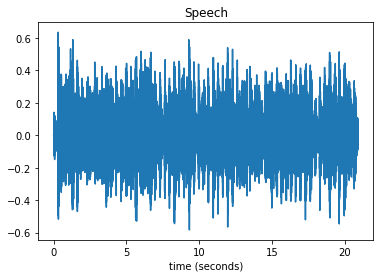

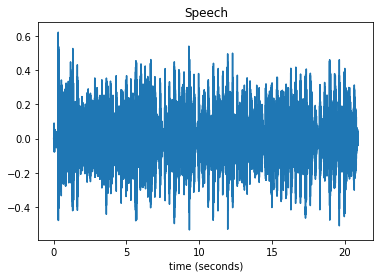

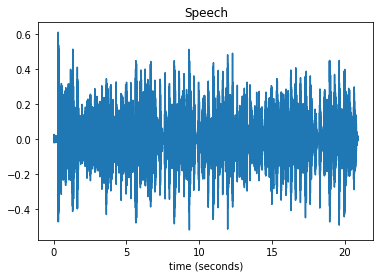

In [12]:
ss = SpectralSubtraction(x, sr)
x1 = ss.simpleSpectralSubtraction()
x2 = ss.BeroutiSpectralSubtraction()
displaySpeech(x,  16000)
displaySpeech(x1, 16000)
displaySpeech(x2, 16000)

# ss.saveWave("./output.wav")
IPython.display.Audio(x, rate=16000)

In [14]:
IPython.display.Audio(x1, rate=16000)

In [15]:
IPython.display.Audio(x2, rate=16000)

In [16]:
wav_name = 'interview-01-001.wav'
ss_wav_name = 'interview-01-001-ss.wav'
x, sr = librosa.load(wav_name, sr=16000)


In [18]:
IPython.display.Audio(x, rate=16000)